In [203]:
import os
from timeit import default_timer as timer
import pandas as pd
from datetime import datetime, timedelta
from glob import glob

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,desc,row_number,col,year,month,dayofmonth,hour,dayofweek,to_timestamp,size,isnan,lit,date_format,to_timestamp,struct,expr
from pyspark.sql.types import MapType, StringType, IntegerType, StructType, StructField, FloatType, ArrayType, DoubleType
from pyspark.ml.feature import QuantileDiscretizer

In [204]:
try:
    spark
except NameError:
    spark=SparkSession.builder.appName("").getOrCreate()

In [216]:
source='cuebiq'
country='US'
admin_id='census_block_group'
demographics=[
'population',
'median_age',
'median_income',
'state']
to_decile=[
'population',
'median_age',
'median_income',
]

source='cuebiq'
country='MX'
admin_id='ageb'
demographics=[
'total_population',
'pop0_14',
'pop15_64',
'pob65_mas',
'wealth_index_10k',
'municipality_name',
'state_name']
to_decile=[
'total_population',
'pop0_14',
'pop15_64',
'pob65_mas',
'wealth_index_10k',
]

if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/covid/data'
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
else:
    path_to_data='/user/spf248/covid/data'
    import matplotlib as mpl
    if os.environ.get('DISPLAY','') == '':
        mpl.use('Agg')
    import matplotlib.pyplot as plt
    import seaborn as sns

# Import Aggregated Data

In [ ]:
n_pings_id_date=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'n_pings_id_date')) # 1607730544
n_pings_id_personal_date=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'n_pings_id_personal_date')) # 1569849911
personal_admin=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'personal_admin')) # 217190
primary_home=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'primary_home')) # 2132327
users_profile=spark.read.parquet(os.path.join(path_to_data,source,'aggregates',country,'users_profile')) # 21783569

# Merge and Aggregate by Population Groups

In [ ]:
to_keep=[
'date',
'n_home',
'n_pings',
# 'n_days',
# 'n_personal',
# 'device_type',
]+demographics

n_pings_id_home_date=n_pings_id_personal_date.withColumnRenamed(
'n_pings','n_home').join(n_pings_id_date,on=['cuebiq_id','date']).join(
primary_home.select('cuebiq_id','point',admin_id),
on=['cuebiq_id','point']).drop('point').join(
personal_admin.drop('point'),on=[admin_id]).join(
users_profile.drop('n_pings'),on=['cuebiq_id']).select(to_keep)

print(n_pings_id_home_date.printSchema())

In [ ]:
n_pings_id_home_date=n_pings_id_home_date.select(*(col(c).cast("float").alias(c) 
if c in to_decile else col(c) for c in n_pings_id_home_date.columns))
n_pings_id_home_date.cache()
print('# Obs:', n_pings_id_home_date.count())

for _var in to_decile:
    print('Discretize:', _var)
    qds=QuantileDiscretizer(
    numBuckets=10, 
    inputCol=_var, 
    outputCol=_var+"_decile")
    n_pings_id_home_date=qds.fit(n_pings_id_home_date).setHandleInvalid("skip").transform(n_pings_id_home_date)
    print(n_pings_id_home_date.printSchema())

In [ ]:
n_pings_id_home_date.groupby(['date']+[x+'_decile' if x in to_decile else x for x in demographics]).agg(
{'n_home':'sum','n_pings':'sum'}).withColumnRenamed(
'sum(n_home)','n_home').withColumnRenamed(
'sum(n_pings)','n_pings').write.mode("overwrite").parquet(
os.path.join(path_to_data,source,'aggregates',country,'home_presence'))

# FIGURES

In [223]:
n_pings_id_home_date=spark.read.parquet(
os.path.join(path_to_data,source,'aggregates',country,'home_presence'))

In [224]:
print('Save Primary Home Location')
start = timer()
n_pings_id_home_date_pd=n_pings_id_home_date.toPandas()
print("Done in", round(timer()-start), "sec")     

Save Primary Home Location
Done in 14 sec


In [225]:
date_range=pd.Series(sorted([
pd.to_datetime(x.split('/')[-1][:-2],format='%Y%m%d') 
for x in glob(os.path.join(path_to_data,source,'s3',country,'2020*'))]))

In [226]:
n_pings_id_home_date_pd.sort_values(
by=['date']+[x+'_decile' if x in to_decile else x for x in demographics],inplace=True)

currentYear = datetime.now().year
n_pings_id_home_date_pd['keep_date']=n_pings_id_home_date_pd.date.apply(lambda x:int(x.split('-')[0])==currentYear)
n_pings_id_home_date_pd=n_pings_id_home_date_pd.loc[n_pings_id_home_date_pd.keep_date==True].copy()
n_pings_id_home_date_pd.date=pd.to_datetime(n_pings_id_home_date_pd.date)
n_pings_id_home_date_pd=n_pings_id_home_date_pd[n_pings_id_home_date_pd.date<date_range.iloc[-1]].copy()
n_pings_id_home_date_pd.drop('keep_date',1,inplace=True)

In [227]:
range_by_state=n_pings_id_home_date_pd.groupby(['state_name','date']).agg(
{'n_home':'sum','n_pings':'sum'}).apply(
lambda x:x.n_home/x.n_pings,1).groupby('state_name').apply(
lambda x:(x.max()-x.min())/x.mean()).sort_values()

In [228]:
range_by_state

state_name
Veracruz de Ignacio de la Llave    0.349599
Oaxaca                             0.364130
Hidalgo                            0.374169
Michoacán de Ocampo                0.374797
Sinaloa                            0.410416
Puebla                             0.411941
Guerrero                           0.421985
Chiapas                            0.438966
Tlaxcala                           0.446038
San Luis Potosí                    0.449467
Guanajuato                         0.451708
Baja California Sur                0.479970
Durango                            0.484828
Zacatecas                          0.508367
Morelos                            0.509602
México                             0.533341
Baja California                    0.553439
Sonora                             0.554634
Tabasco                            0.569695
Jalisco                            0.578277
Distrito Federal                   0.585198
Colima                             0.593262
Tamaulipas           

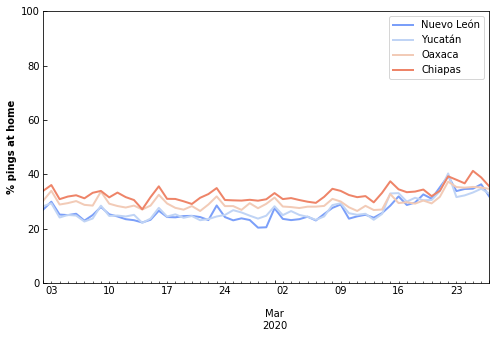

In [229]:
fig,ax=plt.subplots(figsize=(8,5))
for i,state in enumerate(['Nuevo León','Yucatán','Oaxaca','Chiapas']):
    n_pings_id_home_date_pd.groupby(['state_name','date']).agg(
    {'n_home':'sum','n_pings':'sum'}).apply(
    lambda x:x.n_home/x.n_pings*100,1).loc[state].truncate(before=datetime.now()-timedelta(days = 70)).plot(
    ax=ax,label=state,linewidth=2,color=sns.color_palette("coolwarm", 4)[i])
    ax.set_ylim([0,100])
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('')
ax.set_ylabel('% pings at home',fontweight='bold')
ax.legend(loc='best')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'home-presence-by-state.pdf'),bbox_inches='tight')

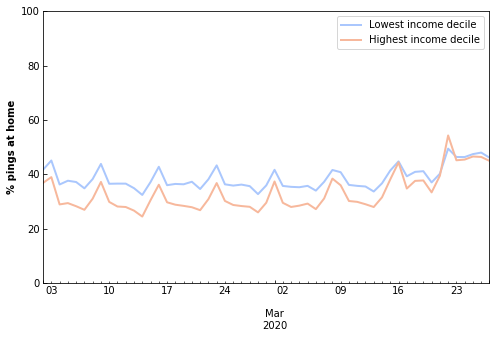

In [230]:
fig,ax=plt.subplots(figsize=(8,5))
for i,(income_group,income_label) in enumerate(zip([0,9],['Lowest income decile','Highest income decile'])):
    n_pings_id_home_date_pd.groupby(['wealth_index_10k_decile','date']).agg(
    {'n_home':'sum','n_pings':'sum'}).apply(
    lambda x:x.n_home/x.n_pings*100,1).loc[income_group].truncate(before=datetime.now()-timedelta(days = 70)).plot(
    ax=ax,label=income_label,linewidth=2,color=sns.color_palette("coolwarm", 2)[i])
    ax.set_ylim([0,100])
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('')
ax.set_ylabel('% pings at home',fontweight='bold')
ax.legend(loc='best')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'home-presence-by-income-group.pdf'),bbox_inches='tight')

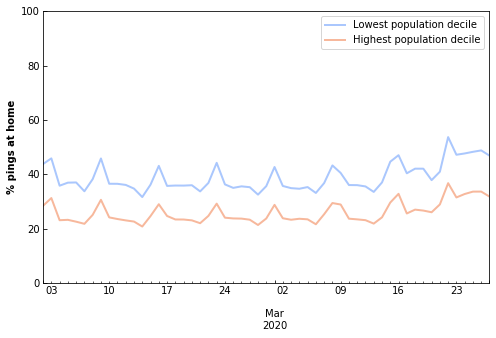

In [231]:
fig,ax=plt.subplots(figsize=(8,5))
for i,(population_group,population_label) in enumerate(zip([0,9],['Lowest population decile','Highest population decile'])):
    n_pings_id_home_date_pd.groupby(['total_population_decile','date']).agg(
    {'n_home':'sum','n_pings':'sum'}).apply(
    lambda x:x.n_home/x.n_pings*100,1).loc[population_group].truncate(before=datetime.now()-timedelta(days = 70)).plot(
    ax=ax,label=population_label,linewidth=2,color=sns.color_palette("coolwarm", 2)[i])
    ax.set_ylim([0,100])
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('')
ax.set_ylabel('% pings at home',fontweight='bold')
ax.legend(loc='best')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'home-presence-by-population-group.pdf'),bbox_inches='tight')

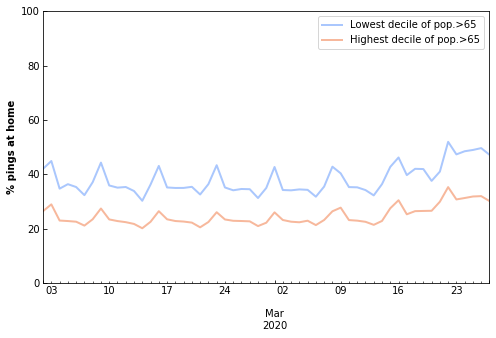

In [232]:
fig,ax=plt.subplots(figsize=(8,5))
for i,(age_group,age_label) in enumerate(zip([0,9],['Lowest decile of pop.>65','Highest decile of pop.>65'])):
    n_pings_id_home_date_pd.groupby(['pob65_mas_decile','date']).agg(
    {'n_home':'sum','n_pings':'sum'}).apply(
    lambda x:x.n_home/x.n_pings*100,1).loc[age_group].truncate(before=datetime.now()-timedelta(days = 70)).plot(
    ax=ax,label=age_label,linewidth=2,color=sns.color_palette("coolwarm", 2)[i])
    ax.set_ylim([0,100])
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xlabel('')
ax.set_ylabel('% pings at home',fontweight='bold')
ax.legend(loc='best')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'home-presence-by-age-group.pdf'),bbox_inches='tight')